# Audio-to-audio generation 

<div style="text-align:center;">
<img src="../images/method.png" alt="Example Image" width="800" />
</div>


This notebook implements the inference for audio-to-audio generation. We demonstrate using the demo samples from the [webpage](https://nilsdem.github.io/control-transfer-diffusion/), but you can load your own structure and timbre targets. 
Please note that although any structure input can be used, the model require samples from the datasets (or quite similar) for the timbre target.


Make sure to [download]() the pretrained models and place them in `./pretrained`. Two pretrained models are available, one trained on [SLAKH 2100](http://www.slakh.com/), and one trained on multiple real-world instrumental recordings (Maestro, URMP, Filobass, GuitarSet...).

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import gin

gin.enter_interactive_mode()

from IPython.display import display, Audio
import torch
import numpy as np
import librosa

import sys

sys.path.append('..')

torch.set_grad_enabled(False)

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


### Checkpoint setup

In [18]:
# Import paths
folder = "../runs/midi_lowadv"
step = 550000
checkpoint_path = folder + "/checkpoint" + str(step) + "_EMA.pt"
config = folder + "/config.gin"

autoencoder_path = "../pretrained/slakh.ts"

# GPU
device = "cuda:0"

### Instantiate te model and load the checkpoint

In [19]:
from diffusion.model import RectifiedFlow

# Parse config
gin.parse_config_file(config)
SR = gin.query_parameter("%SR")

# Emb model

# Instantiate model
blender = RectifiedFlow(device=device)

# Load checkpoints
state_dict = torch.load(checkpoint_path, map_location="cpu")["model_state"]
blender.load_state_dict(state_dict, strict=False)

# Emb model
emb_model = torch.jit.load(autoencoder_path).eval()
blender.emb_model = emb_model

# Send to device
blender = blender.eval().to(device)

/data/nils/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_1330069/377124465.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for

FileNotFoundError: [Errno 2] No such file or directory: '../runs/midi_lowadv/checkpoint550000_EMA.pt'

### Load the dataset

In [5]:
from acids_datasets import SimpleDataset

db_path = "/data/nils/datasets/instruments/slakh/slakh2100_flac_redux/slakh_2048/"
dataset = SimpleDataset(path=db_path, keys=["waveform", "z", "midi"])

In [6]:
n_signal = 64
bsize = 64
ae_ratio = 2048
structure_type = "midi"


def crop(arrays, length, idxs):
    return [
        torch.stack([xc[..., i:i + length] for i, xc in zip(idxs, array)])
        for array in arrays
    ]


def normalize(array):
    return (array - array.min()) / (array.max() - array.min() + 1e-6)


def collate_fn(batch):
    x = torch.from_numpy(np.stack([b["z"] for b in batch], axis=0))
    i0 = np.random.randint(0, x.shape[-1] - n_signal, x.shape[0])
    x_target = crop([x], n_signal, i0)[0]
    i1 = np.random.randint(0, x.shape[-1] - n_signal, x.shape[0])
    x_timbre = crop([x], n_signal, i1)[0]
    if blender.time_transform is not None:
        x_waveform = torch.from_numpy(
            np.stack([b["waveform"] for b in batch], axis=0))
        x_waveform = x_waveform.reshape(x_waveform.shape[0], 1, -1)
        time_cond_target = crop([x_waveform], n_signal * ae_ratio,
                                i0 * ae_ratio)[0]
    elif structure_type == "audio":
        time_cond_target = x_target
    elif structure_type == "midi":
        midi = [b["midi"] for b in batch]
        times = np.linspace(
            0, x.shape[-1] * ae_ratio / gin.query_parameter("%SR"),
            x.shape[-1])
        pr = [m.get_piano_roll(times=times) for m in midi]
        #print(p.shape for p in pr)
        pr = map(normalize, pr)
        pr = np.stack(list(pr))
        pr = torch.from_numpy(pr).float()
        pr = torch.stack([prc[..., i:i + n_signal] for i, prc in zip(i0, pr)])
        time_cond_target = pr
    return {"x": x_target, "x_cond": x_timbre, "x_time_cond": time_cond_target}


train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=bsize,
                                           shuffle=False,
                                           num_workers=16,
                                           drop_last=True,
                                           collate_fn=collate_fn)

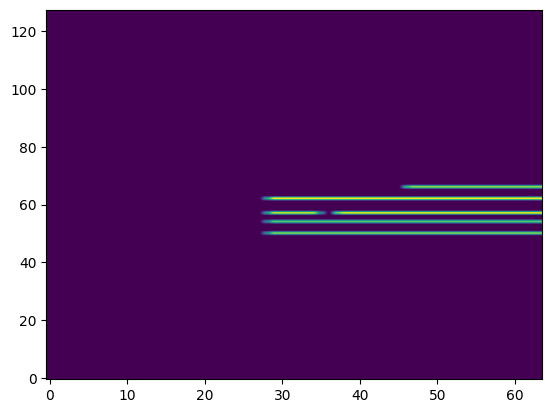

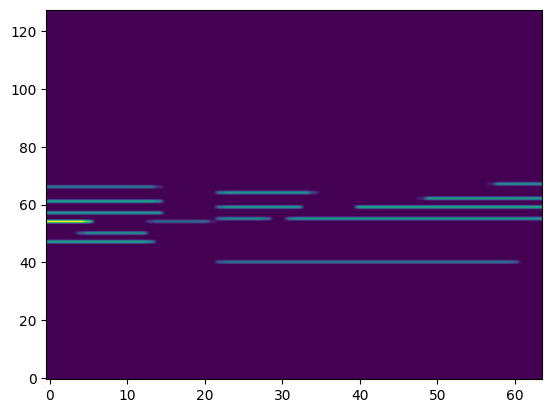

In [ ]:
import matplotlib.pyplot as plt

batch = next(iter(train_loader))

z = batch["x"]
pr = batch["x_time_cond"]

z1, z2 = z[:2].unsqueeze(1).to(device)

pr1, pr2 = pr[:2].unsqueeze(1).to(device)

x1, x2 = blender.emb_model.decode(
    z1).cpu().squeeze(), blender.emb_model.decode(z2).cpu().squeeze()

display(Audio(x1, rate=SR))
display(Audio(x2, rate=SR))

plt.imshow(pr[0].cpu().numpy(), aspect="auto", origin="lower")
plt.show()
plt.imshow(pr[1].cpu().numpy(), aspect="auto", origin="lower")

#### Generation

In [8]:
nb_steps = 20  #Number of diffusion steps
guidance = 1.0  #Classifier free guidance strength

In [ ]:
pr1.shape

torch.Size([1, 128, 64])

In [15]:
# Compute structure representation
time_cond1, time_cond2 = blender.encoder_time(pr1), blender.encoder_time(pr2)

# Compute timbre representation
zsem1, zsem2 = blender.encoder(z1), blender.encoder(z2)

zsem = zsem2
time_cond = time_cond2

# Sample initial noise
x0 = torch.randn_like(z1)

print("Normal")
total_guidance = 1.0
guidance_joint_factor = 1.0
guidance_cond_factor = 0

xS = blender.sample(
    x0,
    time_cond=time_cond,
    cond=zsem,
    nb_steps=nb_steps,
    guidance_cond_factor=guidance_cond_factor,
    guidance_joint_factor=guidance_joint_factor,
    total_guidance=total_guidance,
)

audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
display(Audio(audio_out, rate=SR))

print("MOre guidance")
total_guidance = 3.

guidance_joint_factor = 0.
guidance_cond_factor = 0.0

xS = blender.sample(
    x0,
    time_cond=time_cond,
    cond=zsem,
    nb_steps=nb_steps,
    guidance_cond_factor=guidance_cond_factor,
    guidance_joint_factor=guidance_joint_factor,
    total_guidance=total_guidance,
)

audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
display(Audio(audio_out, rate=SR))

print("no zsem")
for k in range(3):

    total_guidance = 1.0
    guidance_joint_factor = 0.
    guidance_cond_factor = 0.

    xS = blender.sample(
        torch.randn_like(x0),
        time_cond=time_cond,
        cond=zsem,
        nb_steps=nb_steps,
        guidance_cond_factor=guidance_cond_factor,
        guidance_joint_factor=guidance_joint_factor,
        total_guidance=total_guidance,
    )
    audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
    display(Audio(audio_out, rate=SR))

print("no time_cond")
for k in range(3):

    total_guidance = 1.0
    guidance_joint_factor = 0.
    guidance_cond_factor = 1.

    xS = blender.sample(
        torch.randn_like(x0),
        time_cond=time_cond,
        cond=zsem,
        nb_steps=nb_steps,
        guidance_cond_factor=guidance_cond_factor,
        guidance_joint_factor=guidance_joint_factor,
        total_guidance=total_guidance,
    )
    audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
    display(Audio(audio_out, rate=SR))

total_guidance = 2.
guidance_joint_factor = 0.4

for guidance_cond_factor in [0.2, 0.8]:
    print(f"Guidance cond factor: {guidance_cond_factor}")
    xS = blender.sample(
        x0,
        time_cond=time_cond,
        cond=zsem,
        nb_steps=nb_steps,
        guidance_cond_factor=guidance_cond_factor,
        guidance_joint_factor=guidance_joint_factor,
        total_guidance=total_guidance,
    )

    audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
    display(Audio(audio_out, rate=SR))

Normal


MOre guidance


no zsem


no time_cond


Guidance cond factor: 0.2


Guidance cond factor: 0.8


In [ ]:
time_cond1

tensor([[[-1.8646, -1.8974, -1.8866,  ..., -1.9127, -1.9080, -1.9085],
         [-1.7828, -1.7490, -1.7806,  ..., -1.8510, -1.8325, -1.8188],
         [-1.7033, -1.6996, -1.7211,  ..., -1.7547, -1.7173, -1.6902],
         ...,
         [-1.7052, -1.6940, -1.5693,  ..., -1.4744, -1.5168, -1.6461],
         [-1.4201, -1.4469, -1.3687,  ..., -1.4599, -1.4937, -1.5424],
         [-1.7802, -1.8681, -1.8205,  ..., -1.9615, -1.9432, -1.8912]]],
       device='cuda:0')

(array([2., 3., 0., 4., 3., 4., 8., 3., 3., 2.]),
 array([-0.94222462, -0.79892915, -0.65563363, -0.51233816, -0.36904269,
        -0.2257472 , -0.08245172,  0.06084377,  0.20413926,  0.34743473,
         0.49073023]),
 <BarContainer object of 10 artists>)

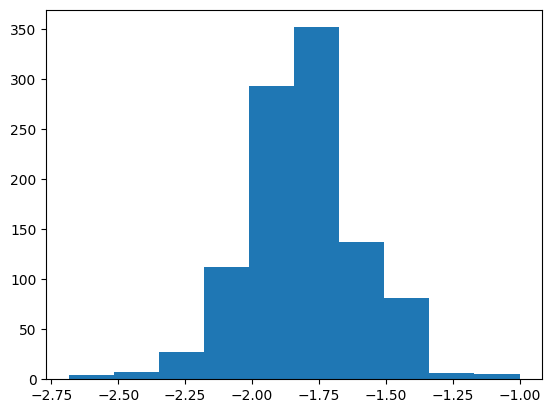

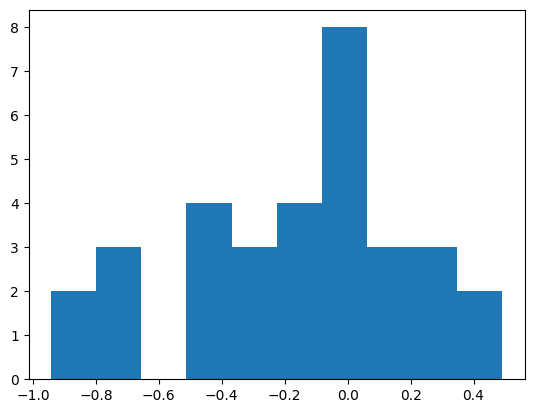

In [ ]:
import matplotlib.pyplot as plt

plt.hist(time_cond.flatten().cpu())
plt.figure()
plt.hist(zsem.flatten().cpu())